In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import torch.nn.functional as F

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [4]:
def inv_mee(true_target, predicted_target):
    return 1/mee(true_target, predicted_target)

In [5]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [6]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values

In [7]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


In [8]:
RS_NUMBER = 69

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS_NUMBER)
print(f"X train shape: {X.shape}")
print(f"X validation shape: {X_test.shape}")
print(f"y train shape: {y.shape}")
print(f"y validation shape: {y_test.shape}")

X train shape: (1329, 10)
X validation shape: (148, 10)
y train shape: (1329, 2)
y validation shape: (148, 2)


In [10]:
class MyModule(nn.Module):
    def __init__(self, num_units, activation_fun, hidden_layers):
        super(MyModule, self).__init__()
        
        if(activation_fun == "sigmoid"):
            activation_fun = nn.Sigmoid()
        elif activation_fun == "relu":
            activation_fun = nn.ReLU()
        elif activation_fun == "tanh":
            activation_fun = nn.Tanh()
            
        if hidden_layers == 2:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )
        elif hidden_layers == 1:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )     
    def forward(self, x):
        X = self.linear_stack(x)
        return X
    
    def predict(self, x):
        X = self.linear_stack(x)
        return X

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MyModule(num_units=100, activation_fun = "sigmoid", hidden_layers = 1).to(device)
print(model)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [12]:
model = NeuralNetRegressor(
    module = MyModule
)

In [13]:
# define the number of iterations
n_iter_search = 100
# define number of k-folds
k = 10
RS_NUMBER = 69

In [14]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(0.0001, 0.1),
    'max_epochs': randint(50, 500),
    'optimizer': [torch.optim.SGD],
    #'criterion': [nn.BCELoss],
    'optimizer__momentum': [0.8, 0.9, 0.95, 0.85],
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1],
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(5, 128),
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(1, X.shape[0]),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(inv_mee), #scoring is based on the highest value
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [16]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=True, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/pytorch_search.csv")

In [17]:
df_results = pd.read_csv("pytorch_results/pytorch_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,52,5.003209,0.118703,0.004350,0.001112,525,0.023882,231,sigmoid,1,...,0.796305,0.824534,0.800794,0.884659,0.924938,0.809152,0.981634,0.876031,0.064402,1
1,57,11.609505,0.346065,0.004026,0.001023,304,0.003199,432,tanh,2,...,0.829902,0.799943,0.806206,0.881460,0.944821,0.785525,0.969432,0.872926,0.066748,2
2,43,8.331176,0.292345,0.003958,0.001316,1121,0.022958,429,tanh,1,...,0.816276,0.808714,0.802433,0.869786,0.927757,0.793308,0.907726,0.868457,0.062101,3
3,20,10.215750,0.353221,0.004155,0.001031,1227,0.006878,441,tanh,2,...,0.813090,0.815658,0.796605,0.853289,0.928002,0.805441,0.943928,0.866816,0.056776,4
4,58,5.581401,0.269410,0.004151,0.001912,405,0.003487,244,tanh,1,...,0.795758,0.811711,0.812070,0.888662,0.946810,0.770579,0.923717,0.861921,0.062288,5


In [18]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (invMEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (invMEE) on best model: 0.8760309958431405

Best params: {'batch_size': 525, 'lr': 0.02388213356411444, 'max_epochs': 231, 'module__activation_fun': 'sigmoid', 'module__hidden_layers': 1, 'module__num_units': 51, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.95, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.001}


In [63]:
#TODO transform best_param_ into a dict
BATCH=525
EPOCHS=231
LR=0.02388213356411444
WEIGHT_DECAY = 0.001
NESTEROV=False
NUM_UNITS=51
ACTIVATION_FUN='sigmoid'
OPTIMIZER='SGD'
HIDDEN_LAYERS=1
MOMENTUM=0.9


In [46]:
class CupDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = CupDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = CupDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = CupDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [47]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
model = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
model.to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=NESTEROV)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=51, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=51, out_features=2, bias=True)
  )
)


In [65]:
loss_stats = {
    'train': [],
    "val": []
}

In [51]:
#function to define the train phase
def TrainPhase_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        #y_pred1 = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        #single_loss1 = loss1(y_pred1, y_batch1)
        #single_loss2 = loss2(y_pred2, y_batch2)
        #single_loss = torch.add(single_loss1, single_loss2)

        #acc = binary_acc(y_pred, y_batch)
             
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        #epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    #aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses

In [52]:
#function to define the evaluate phase
def Evaluate_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            #y_pred1, y_pred2 = model(X_batch)

            loss = loss_f(y_test_pred, y_batch)
            #loss1 = loss_f1(y_pred1, y_batch1)
            #loss2 = loss_f2(y_pred2, y_batch2)
            #loss = torch.add(loss1, loss2)
            
            #acc = binary_acc(y_test_pred, y_batch)

            epoch_loss += loss.item()
            #epoch_loss += loss.item()*X_batch.size(0)
            #epoch_acc += acc.item()

            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    aggregated_losses.append(epoch_loss/len(data_test))
    #aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f}')
    
    return aggregated_losses
    

In [53]:
#function to define the evaluate phase
def Result_Cup(model, X_batch):
    
    y_pred_list = []
    model.eval()

    with torch.no_grad():
        #for X_batch, _ in data_test:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy()) 

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]    
    return y_pred_list
    

In [66]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train = TrainPhase_Cup(epoch, model, losses_train, accuracies_train, train_loader, criterion, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  losses_test = Evaluate_Cup(epoch, model, losses_test, accuracies_test, val_loader, mee)
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 127.37417
VALIDATION - Epoch 001: | Loss: 9.85895
##############################
TRAIN - Epoch 002: | Loss: 108.04677
VALIDATION - Epoch 002: | Loss: 7.19593
##############################
TRAIN - Epoch 003: | Loss: 28.32041
VALIDATION - Epoch 003: | Loss: 11.01094
##############################
TRAIN - Epoch 004: | Loss: 74.48035
VALIDATION - Epoch 004: | Loss: 8.94185
##############################
TRAIN - Epoch 005: | Loss: 27.61208
VALIDATION - Epoch 005: | Loss: 5.42429
##############################
TRAIN - Epoch 006: | Loss: 25.85292
VALIDATION - Epoch 006: | Loss: 6.94907
##############################
TRAIN - Epoch 007: | Loss: 22.57155
VALIDATION - Epoch 007: | Loss: 2.62374
##############################
TRAIN - Epoch 008: | Loss: 5.80046
VALIDATION - Epoch 008: | Loss: 4.35379
##############################
TRAIN - Epoch 009: | Loss: 15.33353
VALIDATION - Epoch 009: | Loss: 3.20085
##############################
TRAIN - Epoch 010: | Loss: 5.33701


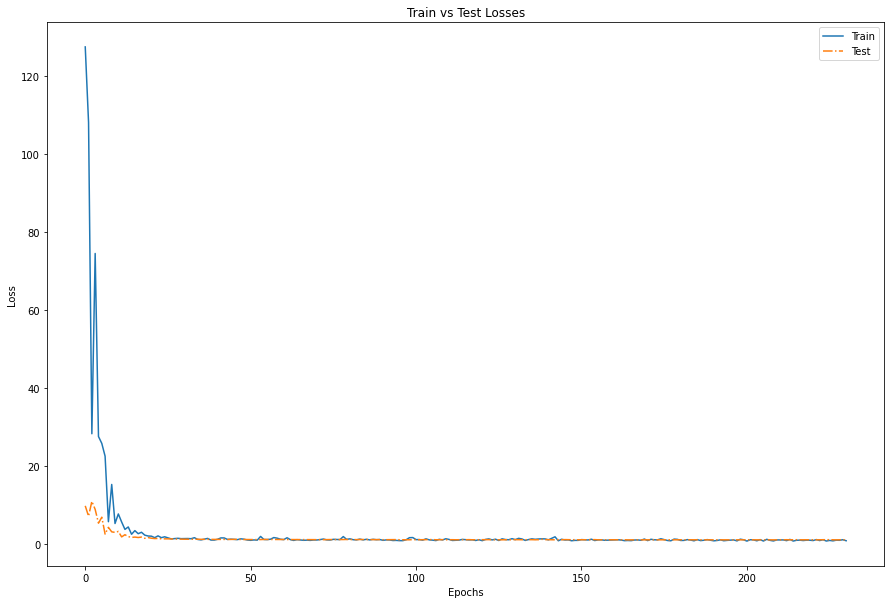

In [67]:
#create a loss plot
plt.figure(figsize=(15,10))
plt.plot(losses_train,'-')

plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>